In [ ]:
pip install transformers

In [ ]:
 pip install emoji

In [ ]:
import nltk
nltk.download('vader_lexicon')

In [ ]:
import nltk
nltk.download('stopwords')

In [ ]:
pip install gensim --upgrade

In [ ]:
pip install https://github.com/JonathanRaiman/glove/archive/master.zip

In [ ]:
pip install vaderSentiment

In [ ]:
pip install plotly --upgrade

In [ ]:
pip install nlp

In [ ]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"


In [ ]:
import nltk
nltk.download('punkt_tab')

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


True

In [ ]:
#---------------------------------LIBRARIES---------------------------------------------------
import numpy as np
import pandas as pd
import kagglehub
import os
import seaborn as sns
import matplotlib.pyplot as plt

import string,time
import re
from textblob import TextBlob
from nltk.corpus import stopwords
import emoji
import spacy
from nltk.stem.porter import PorterStemmer
from nltk.tokenize import word_tokenize,sent_tokenize
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from tqdm import tqdm

import plotly.express as px
import plotly.graph_objects as go
from wordcloud import WordCloud

from pyspark.sql import SparkSession
from sklearn.feature_extraction.text import CountVectorizer
import logging
from sklearn.metrics import confusion_matrix
import nltk

In [ ]:
#------------------------------------------------DATASET--------------------------------------------------------------------------
path = kagglehub.dataset_download("kanchana1990/uber-customer-reviews-dataset-2024")
print("Path to dataset files:", path)
data = pd.read_csv("/kaggle/input/uber-customer-reviews-dataset-2024/uber_reviews_without_reviewid.csv")
data.info()
data.drop(columns = ["userImage", "replyContent", "repliedAt", "appVersion","at", "reviewCreatedVersion", "userName"], axis =1, inplace = True)
data.head(5)

Path to dataset files: /kaggle/input/uber-customer-reviews-dataset-2024
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12000 entries, 0 to 11999
Data columns (total 10 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   userName              12000 non-null  object 
 1   userImage             0 non-null      float64
 2   content               12000 non-null  object 
 3   score                 12000 non-null  int64  
 4   thumbsUpCount         12000 non-null  int64  
 5   reviewCreatedVersion  10260 non-null  object 
 6   at                    12000 non-null  object 
 7   replyContent          33 non-null     object 
 8   repliedAt             33 non-null     object 
 9   appVersion            10260 non-null  object 
dtypes: float64(1), int64(2), object(7)
memory usage: 937.6+ KB


,content,score,thumbsUpCount
0,Good,5,0
1,Nice,5,0
2,Very convenient,5,0
3,Good,4,0
4,exllence,5,0


In [ ]:
#-------------------------------------------------DATASET FILTERING-------------------------------------------------------------

spark = SparkSession.builder.appName("UberReviewsAnalysis").getOrCreate()
df_spark = spark.createDataFrame(data)
df_spark.createOrReplaceTempView("UberReviewsAnalysis")

query = """
SELECT score,  COUNT(*) AS count
FROM UberReviewsAnalysis
GROUP BY score
ORDER BY count DESC
"""

result = spark.sql(query)
result.show(50)

query1 = """
SELECT score, thumbsUpCount, COUNT(*) AS count
FROM UberReviewsAnalysis
GROUP BY score, thumbsUpCount
ORDER BY count DESC
"""

result1 = spark.sql(query1)
result1.show(50)

query2 = """
SELECT content, score, COUNT(*) AS count
FROM UberReviewsAnalysis
GROUP BY content, score
ORDER BY count DESC
"""

result2 = spark.sql(query2)
result2.show(50)


+-----+-----+
|score|count|
+-----+-----+
|    5| 7926|
|    1| 2618|
|    4|  806|
|    3|  333|
|    2|  317|
+-----+-----+

+-----+-------------+-----+
|score|thumbsUpCount|count|
+-----+-------------+-----+
|    5|            0| 7883|
|    1|            0| 2208|
|    4|            0|  792|
|    3|            0|  300|
|    2|            0|  265|
|    1|            1|  212|
|    1|            2|   63|
|    1|            3|   31|
|    2|            1|   24|
|    5|            1|   23|
|    1|            4|   14|
|    3|            1|   12|
|    2|            2|    8|
|    4|            1|    8|
|    1|            7|    7|
|    1|            5|    6|
|    5|            2|    6|
|    1|           66|    4|
|    1|           11|    4|
|    5|            5|    4|
|    1|            8|    4|
|    3|            4|    3|
|    2|            7|    3|
|    1|           10|    3|
|    1|           22|    3|
|    1|           12|    3|
|    2|            3|    3|
|    1|            6|    3|
|    

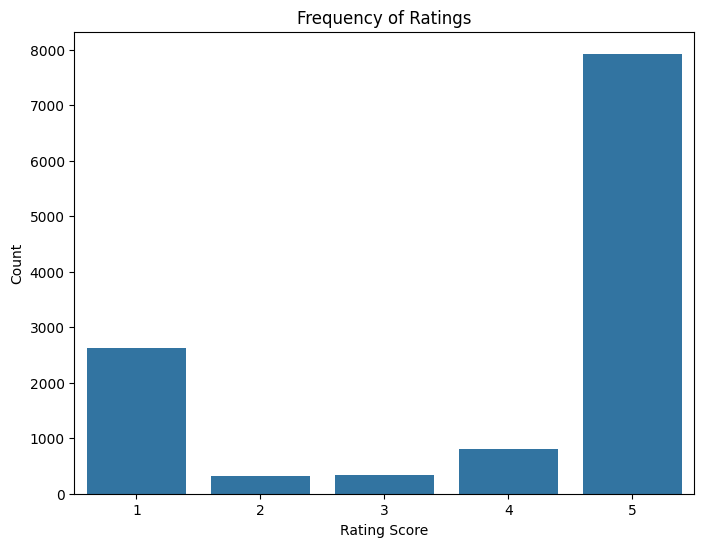

In [ ]:
#--------------------------VISUAL REPRESENTATION OF THE DATA-------------------------------------------
df = pd.DataFrame(data)
plt.figure(figsize=(8, 6))
sns.countplot(x='score', data=df)
plt.title('Frequency of Ratings')
plt.xlabel('Rating Score')
plt.ylabel('Count')
plt.show()

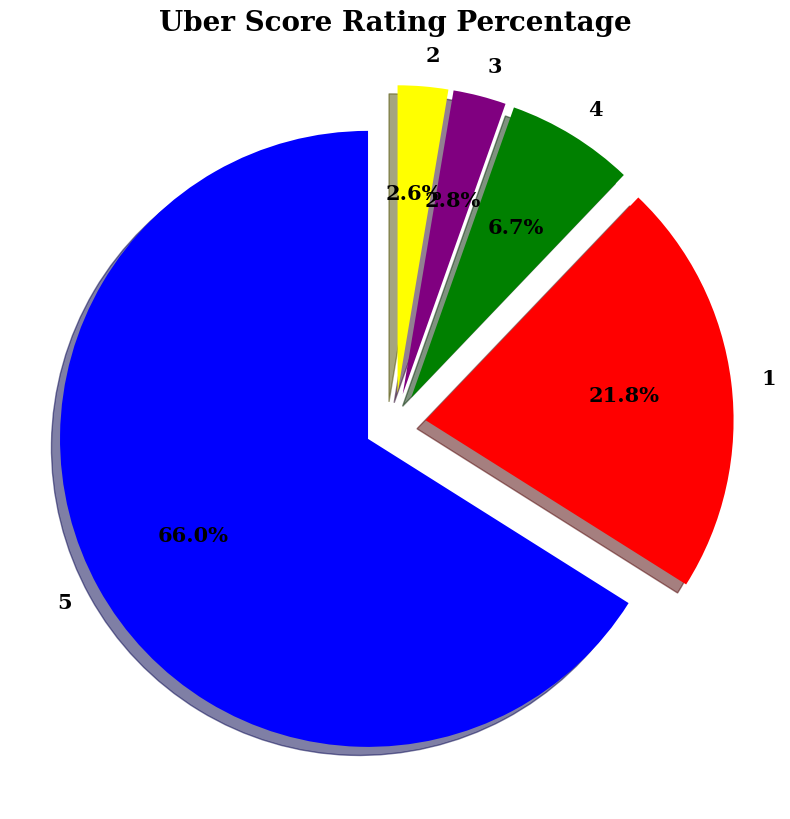

In [ ]:
#-------------------------------------------------------------------VISUAL REPRESENTATION OF THE DATA-------------------------------------------
label_data = df['score'].value_counts()
explode = (0.1, 0.1, 0.1, 0.1 , 0.1)
plt.figure(figsize=(14, 10))
plt.pie(label_data,labels = label_data.index, colors = ['blue', 'red', 'green', 'purple', 'yellow'], pctdistance = 0.65,shadow = True, startangle = 90,explode = explode,autopct = '%1.1f%%', textprops={ 'fontsize': 15,'color': 'black','weight': 'bold','family': 'serif' })
hfont = {'fontname':'serif', 'weight': 'bold'}
plt.title('Uber Score Rating Percentage', size=20, **hfont)
fig = plt.gcf()
plt.show()

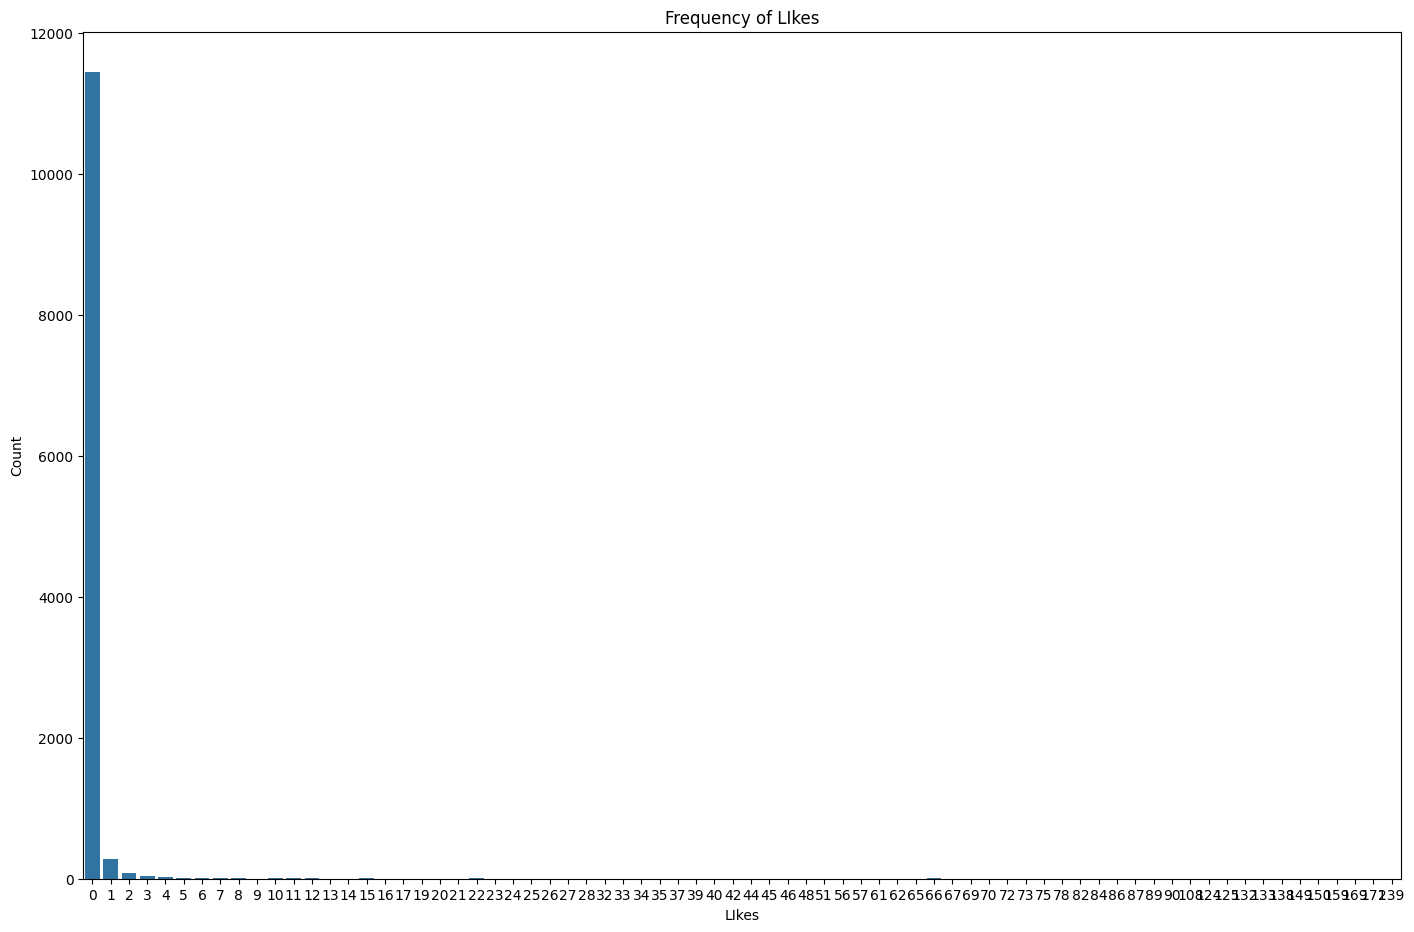

In [ ]:
#-------------------------------------------------------------VISUAL REPRESENTATION OF THE DATA-------------------------------------------
plt.figure(figsize=(17, 11))
sns.countplot(x='thumbsUpCount', data=df)
plt.title('Frequency of LIkes')
plt.xlabel('LIkes')
plt.ylabel('Count')
plt.show()

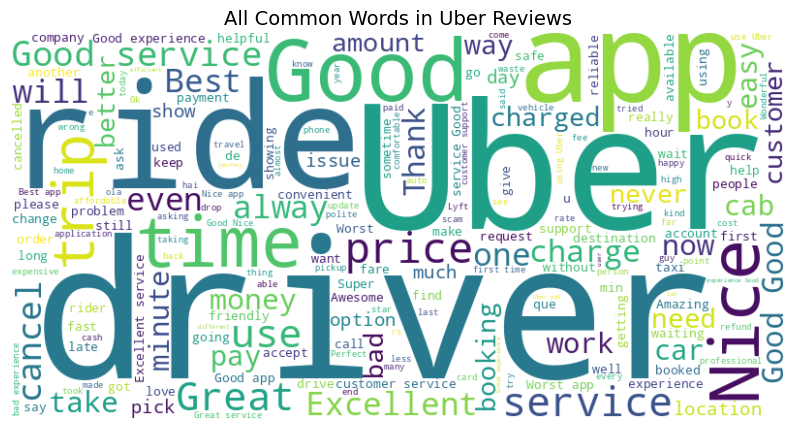

In [ ]:
# ------------------------------------------------------Plot WordCloud for most popular words---------------------------------------------
text = " ".join(df["content"])
wordcloud = WordCloud(width=800, height=400, background_color="white").generate(text)
plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.title("All Common Words in Uber Reviews", fontsize=14)
plt.show()

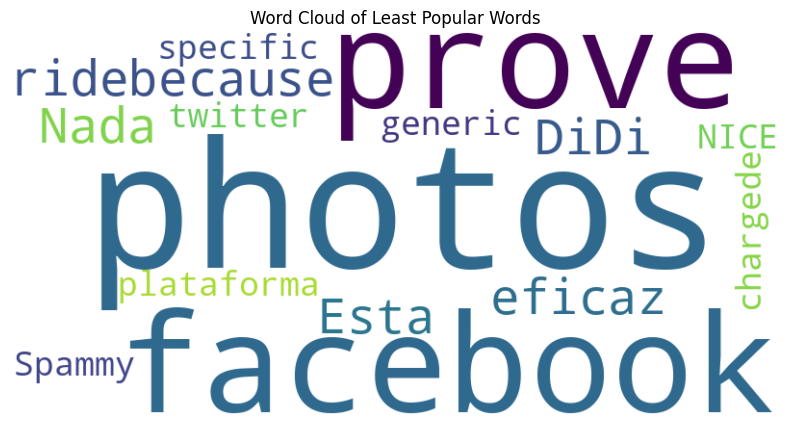

In [ ]:
#--------------------------------------------------------- Word frequency calculation: least popular words------------------------------------------------
text = " ".join(df["content"]).split()
word_counts = pd.Series(text).value_counts()
least_popular_words = word_counts.tail(20)  # Adjust count if needed
wordcloud = WordCloud(width=800, height=400, background_color="white").generate(" ".join(least_popular_words.index))
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.title("Word Cloud of Least Popular Words")
plt.show()

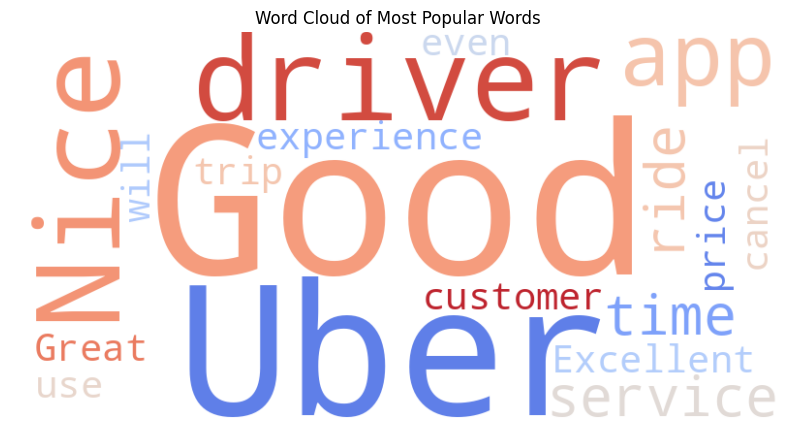

In [ ]:
#--------------------------------------------------------- Word frequency calculation: Most popular words------------------------------------------------
text = " ".join(df["content"]).split()
word_counts = pd.Series(text).value_counts()
most_popular_words = word_counts.head(66)  # Adjust count if needed
wordcloud = WordCloud(width=800, height=400, background_color="white", colormap="coolwarm").generate(" ".join(most_popular_words.index))
plt.figure(figsize=(10, 8))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.title("Word Cloud of Most Popular Words")
plt.show()

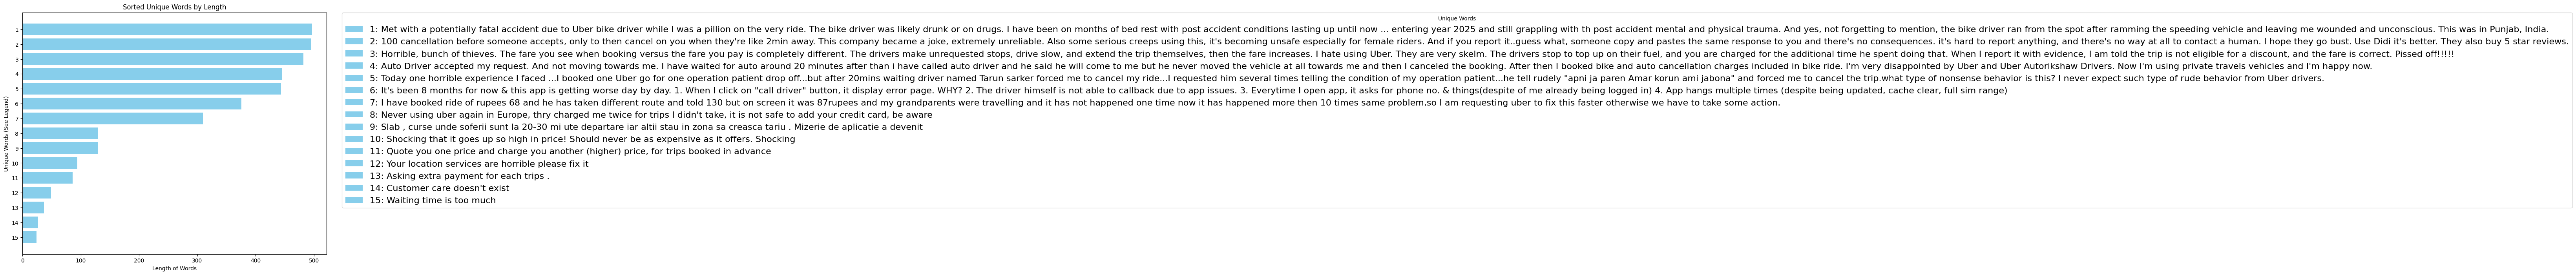

In [ ]:
# ------------------------------------------------Display of all Complaints---------------------------------------------------------
unique_words_score_1 = df[df["score"] == 1]["content"].unique()[:15]
sorted_words = sorted(unique_words_score_1, key=len, reverse=True)
sizes = [len(word) for word in sorted_words]

numbered_labels = [f"{i+1}" for i in range(len(sorted_words))]
fig, ax = plt.subplots(figsize=(10, 8))
bars = ax.barh(numbered_labels, sizes, color="skyblue")  # Store bars for legend mapping
ax.set_xlabel("Length of Words")
ax.set_ylabel("Unique Words (See Legend)")
ax.set_title("Sorted Unique Words by Length")
ax.invert_yaxis()
ax.legend(bars, [f"{i+1}: {word}" for i, word in enumerate(sorted_words)], title="Unique Words",
          loc="upper left", fontsize=16, frameon=True, bbox_to_anchor=(1.05, 1), borderaxespad=0.)

plt.show()

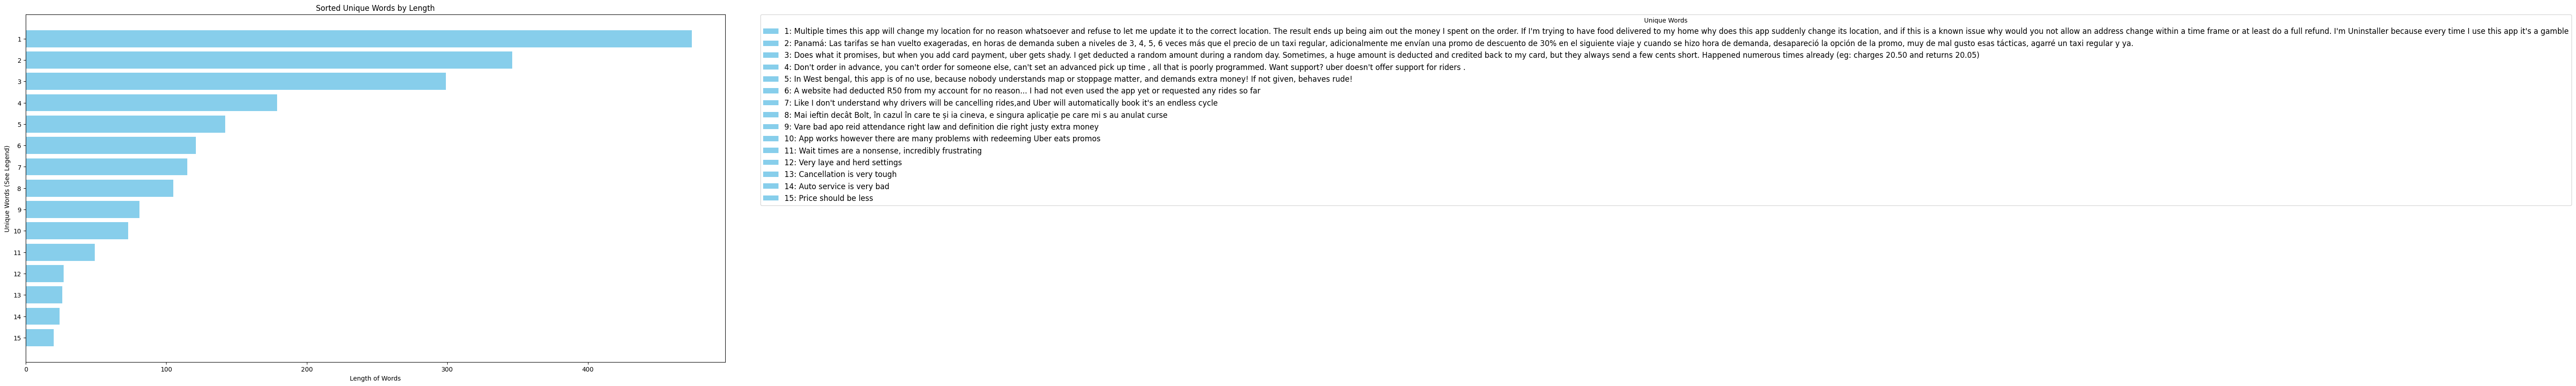

In [ ]:
# ------------------------------------------------Display of all Complaints---------------------------------------------------------
unique_words_score_1 = df[df["score"] == 2]["content"].unique()[:15]
sorted_words = sorted(unique_words_score_1, key=len, reverse=True)
sizes = [len(word) for word in sorted_words]

numbered_labels = [f"{i+1}" for i in range(len(sorted_words))]
fig, ax = plt.subplots(figsize=(20, 10))
bars = ax.barh(numbered_labels, sizes, color="skyblue")  # Store bars for legend mapping
ax.set_xlabel("Length of Words")
ax.set_ylabel("Unique Words (See Legend)")
ax.set_title("Sorted Unique Words by Length")
ax.invert_yaxis()
ax.legend(bars, [f"{i+1}: {word}" for i, word in enumerate(sorted_words)], title="Unique Words",
          loc="upper left", fontsize=12, frameon=True, bbox_to_anchor=(1.05, 1), borderaxespad=0.)

plt.show()

In [ ]:
#---------------------------------------------PREPROCESSING TEXT------------------------------------------------------------
"""
TEXT PRE-PROCESSING: Preprocessing is crucial to normalize the text data before analysis.
This step involves several sub-tasks
"""

df['clean'] = df['content']

#----------------------------Lower-case Conversion--------------------------
df['clean']=df['clean'].str.lower()

#----------------------------Remove Punctuation----------------------
punc =string.punctuation
def remove_punc(text):
    for char in punc:
        text=text.replace(char,'')
    return text
df['clean']= remove_punc(df['clean'])

#------------------------------Remove HTML Tags-------------------------------------
def remove_html_tags(text):  #remove html tages
    pattern = re.compile('<.*?>')
    return pattern.sub('', text)
df['clean']=df['clean'].apply(remove_html_tags)

#-----------------------------Correct spelling Errors----------------------------
#df['clean'] = df['clean'].apply(lambda text: str(TextBlob(text).correct()))


In [ ]:
#----------------------------------Stop Words Removal------------------------------------------
stop_words = set(stopwords.words('english'))

def remove_stopwords(text):
    new_text = []
    for word in text.split():
        if word.lower() not in stop_words:
            new_text.append(word)
    return " ".join(new_text)

df['clean'] = df['clean'].apply(remove_stopwords)

#------------------------------Replace Emoji with text description---------------------
df['clean'] = emoji.demojize(df['clean'])

In [ ]:
#--------------------------------------Apply tokenization and lemmatization--------------------------------------------------------------------
nlp = spacy.load("en_core_web_sm", disable=["ner", "parser"])
texts = df["clean"].astype(str).fillna("").tolist()

def process_texts(texts, nlp, batch_size=1000):
    cleaned = []
    for doc in tqdm(nlp.pipe(texts, batch_size=batch_size, n_process=1), total=len(texts)):
        lemmas = [token.lemma_ for token in doc if not token.is_stop and not token.is_punct]
        cleaned.append(" ".join(lemmas))
    return cleaned


df["clean"] = process_texts(texts, nlp)

In [ ]:
#------------------------------------------------Vectorizing--------------------------------------------------------
vectorizer = CountVectorizer()
X = vectorizer.fit_transform(df['clean'])
vocab = vectorizer.get_feature_names_out()

#------------------------------------------------Bag of Words--------------------------------------------------
bow_df = pd.DataFrame(X.toarray(), columns=vocab)
final_df = pd.concat([df[['Index', 'Output']], bow_df], axis=1)

word_frequencies = bow_df.sum().sort_values(ascending=False)
top_n = 20
top_words = word_frequencies.head(top_n)
plt.figure(figsize=(12, 6))
sns.barplot(x=top_words.values, y=top_words.index, palette="Blues_r")
plt.xlabel("Word Frequency")
plt.ylabel("Words")
plt.title(f"Top {top_n} Most Frequent Words in Bag of Words Representation")
plt.show()

NameError: name 'CountVectorizer' is not defined

In [ ]:
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer
import matplotlib.pyplot as plt
import seaborn as sns


#------------------------------------------------Vectorizing--------------------------------------------------------
vectorizer_orig = CountVectorizer()
X_orig = vectorizer_orig.fit_transform(df['clean'])
vocab_orig = vectorizer_orig.get_feature_names_out()

#------------------------------------------------Bag of Words--------------------------------------------------
# THIS IS THE PRIMARY BOTTLENECK: converting large sparse matrix to dense DataFrame
bow_df_orig = pd.DataFrame(X_orig.toarray(), columns=vocab_orig)
final_df_orig = pd.concat([df[['score', 'Content']], bow_df_orig], axis=1)

word_frequencies_orig = bow_df_orig.sum().sort_values(ascending=False)
top_n = 20
top_words_orig = word_frequencies_orig.head(top_n)

# Plotting (assuming it's not the bottleneck, but including for completeness)
# plt.figure(figsize=(12, 6))
# sns.barplot(x=top_words_orig.values, y=top_words_orig.index, palette="Blues_r")
# plt.xlabel("Word Frequency (Original)")
# plt.ylabel("Words")
# plt.title(f"Top {top_n} Most Frequent Words (Original)")
# plt.show()


#------------------------------------------------Vectorizing (Optimized)--------------------------------------------------------
# 1. Use max_features to limit vocabulary size, reducing memory footprint
# 2. Use min_df/max_df to filter very rare/common words (optional, but good practice)
vectorizer_opt = CountVectorizer(
    max_features=5000,  # Limit the vocabulary size to, e.g., 5000 most frequent words
    min_df=5,           # Ignore words that appear in less than 5 documents
    max_df=0.85         # Ignore words that appear in more than 85% of documents
)
X_opt = vectorizer_opt.fit_transform(df['clean'])
vocab_opt = vectorizer_opt.get_feature_names_out()

#------------------------------------------------Bag of Words (Optimized)--------------------------------------------------
# AVOID .toarray() and dense DataFrame creation if possible for intermediate steps!

# Calculate word frequencies directly from the sparse matrix X_opt
# X_opt.sum(axis=0) sums along the columns (words) for all rows (documents)
word_frequencies_opt = pd.Series(X_opt.sum(axis=0).A1, index=vocab_opt) # .A1 converts 1-row matrix to flat array
word_frequencies_opt = word_frequencies_opt.sort_values(ascending=False)

top_n = 20
top_words_opt = word_frequencies_opt.head(top_n)

# If 'final_df' with all BoW columns is absolutely necessary, consider these alternatives:
# 1. Keep it sparse:
#    final_df_sparse = pd.concat([df[['Index', 'Output']], pd.DataFrame.sparse.from_spmatrix(X_opt, columns=vocab_opt)], axis=1)
#    This is memory efficient but sparse DataFrames have limitations for some operations.

# 2. If you only need a subset of the BoW columns for 'final_df', select them:
#    # Example: Select only the top N words into the final_df
#    top_n_features_X = X_opt[:, vectorizer_opt.vocabulary_[[word for word in top_words_opt.index]]]
#    final_df_subset = pd.concat([df[['Index', 'Output']], pd.DataFrame(top_n_features_X.toarray(), columns=top_words_opt.index)], axis=1)
#    print("\nExample of final_df with only top N words (subset):\n", final_df_subset.head())


# Plotting
plt.figure(figsize=(12, 6))
sns.barplot(x=top_words_opt.values, y=top_words_opt.index, palette="viridis") # Changed palette for distinction
plt.xlabel("Word Frequency")
plt.ylabel("Words")
plt.title(f"Top {top_n} Most Frequent Words in Bag of Words Representation (Optimized)")
plt.tight_layout()
plt.show()

print("\nTop 20 words (optimized):")
print(top_words_opt)

KeyError: "['Content'] not in index"

In [ ]:
#-----------------------------------------------------Plot 10 popular phrases-------------------------------------------------------------------
final_df = pd.concat([df[['clean', 'score']], bow_df], axis=1)

word_frequencies = bow_df.sum().sort_values(ascending=False)
top_n = 20
top_words = word_frequencies.head(top_n)

plt.figure(figsize=(12, 6))
sns.barplot(x=top_words.values, y=top_words.index, palette="Blues_r")
plt.xlabel("Word Frequency")
plt.ylabel("Words")
plt.title(f"Top {top_n} Most Frequent Words in Bag of Words Representation")
plt.show()


NameError: name 'bow_df' is not defined

In [ ]:
#-----------------------------------------------------Plot 10 least popular phrases-------------------------------------------------------------------
final_df = pd.concat([df[['clean', 'score']], bow_df], axis=1)

word_frequencies = bow_df.sum().sort_values(ascending=False)
top_n = 20
top_words = word_frequencies.tail(top_n)

plt.figure(figsize=(12, 6))
sns.barplot(x=top_words.values, y=top_words.index, palette="Blues_r")
plt.xlabel("Word Frequency")
plt.ylabel("Words")
plt.title(f"Top {top_n} Least Frequent Words in Bag of Words Representation")
plt.show()


In [ ]:
#-----------------------Sentiment Intensity Analyzer-------------------------------------------
sid = SentimentIntensityAnalyzer()

df['sentiment']= df['clean'].apply(lambda x: sid.polarity_scores(x))
df = pd.concat([df.drop(['sentiment'], axis=1), df['sentiment'].apply(pd.Series)], axis=1)
df = df.rename(columns={'neu': 'neutral', 'neg': 'negative', 'pos': 'positive'})
df['negative_percentage'] = (df['negative'] / (df['negative'] + df['neutral'] + df['positive'])) * 100
df['neutral_percentage'] = (df['neutral'] / (df['negative'] + df['neutral'] + df['positive'])) * 100
df['positive_percentage'] = (df['positive'] / (df['negative']) + df['neutral'])
df['confidence'] = df[["negative", "neutral", "positive"]].max(axis=1)
df['sentiment'] = df[["negative", "neutral", "positive"]].idxmax(axis=1)

grouped = pd.DataFrame(df['sentiment'].value_counts()).reset_index()
grouped.columns = ['sentiment', 'count']
fig = px.pie(grouped, values='count', names='sentiment', title='Sentiments')
fig.show()

sentiment_labels = ['negative', 'neutral', 'positive']
cm = confusion_matrix(df['score'], df['sentiment'], labels=sentiment_labels)
cm_df = pd.DataFrame(cm, index=sentiment_labels, columns=sentiment_labels)
plt.figure(figsize=(8, 6))
sns.heatmap(cm_df, annot=True, fmt='d', cmap='Blues', xticklabels=sentiment_labels, yticklabels=sentiment_labels)
plt.xlabel("Predicted Sentiment")
plt.ylabel("Actual Sentiment")
plt.title("Sentiment Analysis Confusion Matrix")
plt.show()

In [ ]:
import pandas as pd
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import plotly.express as px # For interactive plots
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
import numpy as np # For handling potential division by zero
import time # For measuring execution time

# --- Dummy Data for Demonstration (Replace with your actual df) ---
# Simulate a large DataFrame
num_rows = 500000 # Half a million rows
df = pd.DataFrame({
    'Index': range(num_rows),
    'clean': ['This is a great movie!'] * int(num_rows * 0.4) +
             ['I feel neutral about this.'] * int(num_rows * 0.3) +
             ['This is absolutely terrible and disappointing.'] * int(num_rows * 0.3) +
             ['A very mixed bag.'] * (num_rows - (int(num_rows * 0.4) + int(num_rows * 0.3) + int(num_rows * 0.3))), # Fill remainder
    'score': ['positive'] * int(num_rows * 0.4) +
             ['neutral'] * int(num_rows * 0.3) +
             ['negative'] * (num_rows - (int(num_rows * 0.4) + int(num_rows * 0.3))) # Dummy actual sentiment for confusion matrix
})
# Ensure 'score' has correct labels for confusion matrix matching
df['score'] = df['clean'].apply(lambda x: 'positive' if 'great' in x else ('negative' if 'terrible' in x else 'neutral'))

print(f"Processing {len(df)} rows...")

# Initialize SentimentIntensityAnalyzer outside the loop/apply
sid = SentimentIntensityAnalyzer()

print("\n--- Sentiment Analysis & Feature Creation ---")
start_time_sentiment = time.time()

# 1. Apply sentiment analysis and directly expand the dictionary output into new columns
# This is more efficient than calling .apply(pd.Series) on the Series of dictionaries later.
# It creates 'neg', 'neu', 'pos', 'compound' columns directly.
sentiment_scores_df = df['clean'].apply(sid.polarity_scores).apply(pd.Series)

# Rename columns for clarity as in your original code
sentiment_scores_df = sentiment_scores_df.rename(columns={'neu': 'neutral', 'neg': 'negative', 'pos': 'positive'})

# Merge the sentiment scores back to the original DataFrame
df = pd.concat([df, sentiment_scores_df], axis=1)

# 2. Corrected and robust percentage calculations
# Add a small epsilon to the denominator to prevent division by zero for rows where all scores are 0
epsilon = 1e-9
df['total_sentiment_score'] = df['negative'] + df['neutral'] + df['positive'] + epsilon

df['negative_percentage'] = (df['negative'] / df['total_sentiment_score']) * 100
df['neutral_percentage'] = (df['neutral'] / df['total_sentiment_score']) * 100
# Corrected positive_percentage calculation
df['positive_percentage'] = (df['positive'] / df['total_sentiment_score']) * 100

# 3. Confidence and predicted sentiment determination
df['confidence'] = df[["negative", "neutral", "positive"]].max(axis=1)
df['sentiment'] = df[["negative", "neutral", "positive"]].idxmax(axis=1)

end_time_sentiment = time.time()
print(f"Sentiment analysis and feature creation completed in {end_time_sentiment - start_time_sentiment:.2f} seconds.")

print("\n--- Plotting Sentiments ---")
start_time_plotting_pie = time.time()

# 4. Pie Chart for Sentiment Distribution
grouped = pd.DataFrame(df['sentiment'].value_counts()).reset_index()
grouped.columns = ['sentiment', 'count']
fig = px.pie(grouped, values='count', names='sentiment', title='Sentiments Distribution')
fig.show()

end_time_plotting_pie = time.time()
print(f"Pie chart plotting completed in {end_time_plotting_pie - start_time_plotting_pie:.2f} seconds.")


print("\n--- Confusion Matrix ---")
start_time_plotting_cm = time.time()

# 5. Confusion Matrix for Sentiment Analysis
# Ensure your 'score' column contains actual sentiment labels (e.g., 'negative', 'neutral', 'positive')
# If 'score' is numeric or different, you'll need to map it to these labels.
# For example, if 'score' is 1-5, you might map 1,2 to 'negative', 3 to 'neutral', 4,5 to 'positive'.

sentiment_labels = ['negative', 'neutral', 'positive'] # Ensure these match your actual and predicted labels

# Filter out any rows where 'score' or 'sentiment' might not be in sentiment_labels
# This prevents errors if there are unexpected values
filtered_df = df[df['score'].isin(sentiment_labels) & df['sentiment'].isin(sentiment_labels)].copy()

# The confusion_matrix function requires that the labels provided are exactly what is found in the data
# If there are missing labels in either actual or predicted that are in sentiment_labels, it can cause issues
# We explicitly set `labels` to ensure the matrix dimensions are correct
cm = confusion_matrix(filtered_df['score'], filtered_df['sentiment'], labels=sentiment_labels)
cm_df = pd.DataFrame(cm, index=sentiment_labels, columns=sentiment_labels)

plt.figure(figsize=(8, 6))
sns.heatmap(cm_df, annot=True, fmt='d', cmap='Blues', xticklabels=sentiment_labels, yticklabels=sentiment_labels)
plt.xlabel("Predicted Sentiment")
plt.ylabel("Actual Sentiment")
plt.title("Sentiment Analysis Confusion Matrix")
plt.tight_layout() # Adjust layout to prevent labels from overlapping
plt.show()

end_time_plotting_cm = time.time()
print(f"Confusion matrix plotting completed in {end_time_plotting_cm - start_time_plotting_cm:.2f} seconds.")

# Display a sample of the updated DataFrame
print("\n--- Sample of DataFrame with Sentiment Scores ---")
print(df[['Index', 'clean', 'negative', 'neutral', 'positive', 'compound',
          'negative_percentage', 'neutral_percentage', 'positive_percentage',
          'confidence', 'sentiment', 'score']].head())

In [ ]:
# Plot positive words
plt.figure(figsize=(10, 6))
plt.bar(positive_words['word'], positive_words['pos'], color='green')
plt.title('Most Positive Popular Words')
plt.xlabel('Words')
plt.ylabel('Positive Sentiment Score')
plt.xticks(rotation=45)
plt.show()

# Plot negative words
plt.figure(figsize=(10, 6))
plt.bar(negative_words['word'], negative_words['neg'], color='red')
plt.title('Most Negative Popular Words')
plt.xlabel('Words')
plt.ylabel('Negative Sentiment Score')
plt.xticks(rotation=45)
plt.show()

In [ ]:
sid = SentimentIntensityAnalyzer()
df['scores'] = df['clean'].apply(lambda x: sid.polarity_scores(x))
df = pd.concat([df.drop(['scores'], axis=1), df['scores'].apply(pd.Series)], axis=1)
df = df.rename(columns={'neu': 'neutral', 'neg': 'negative', 'pos': 'positive'})
df['confidence'] = df[['negative', 'neutral', 'positive']].max(axis=1)
df['predicted_sentiment'] = df[['negative', 'neutral', 'positive']].idxmax(axis=1)
labels = ['negative', 'neutral', 'positive']
cm = confusion_matrix(df['score'], df['predicted_sentiment'], labels=labels)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='YlGnBu', xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted Sentiment')
plt.ylabel('Actual Sentiment')
plt.title('Sentiment Analysis Confusion Matrix')
plt.show()

cm_df = pd.DataFrame(cm, index=labels, columns=labels)
print("Confusion Matrix:")
print(cm_df)


In [ ]:
#------------------------Bidirectional LSTM---------------------------
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Bidirectional
from keras.layers import Embedding
from sklearn.preprocessing import LabelEncoder
labels = LabelEncoder().fit_transform(df['score'])

import numpy as np
unique, counts = np.unique(labels, return_counts=True)
print(dict(zip(unique, counts)))

model = Sequential([
    Embedding(input_dim=2, output_dim=128, input_length=100),
    Bidirectional(LSTM(64, return_sequences=True)),
    Dropout(0.5),
    Bidirectional(LSTM(64)),
    Dense(32, activation='relu'),
    Dropout(0.5),
    Dense(3, activation='softmax')
])

# Compile and fit
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model.fit(padded_sequences, labels, epochs=10, batch_size=32, validation_split=0.2)

test_text = ["The ride was fantastic!", "The driver was unprofessional."]
test_sequences = tokenizer.texts_to_sequences(test_text)
test_padded = pad_sequences(test_sequences, padding='post', maxlen=100)
predictions = model.predict(test_padded)

print("Predicted Sentiments:", predictions.argmax(axis=1))



{np.int64(0): np.int64(2618), np.int64(1): np.int64(317), np.int64(2): np.int64(333), np.int64(3): np.int64(806), np.int64(4): np.int64(7926)}


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


NameError: name 'Dropout' is not defined

In [ ]:
#---------------------------------Sentiment Analysis With Transformer------------------------------------------------------
from transformers import pipeline
sentiment_analyzer = pipeline("sentiment-analysis")

def analyze_sentiment(text):
    result = sentiment_analyzer(text)[0]
    return result['label'], result['score']

df[['Sentiment', 'Confidence']] = df['clean'].apply(lambda x: pd.Series(analyze_sentiment(x)))

sns.countplot(x='Sentiment', data=df)
plt.title('Sentiment Distribution')
plt.show()

In [ ]:
#-------------------------------BERT--------------------------------------------------------------
from transformers import pipeline
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

sentiment_analyzer = pipeline("sentiment-analysis", model="nlptown/bert-base-multilingual-uncased-sentiment")

def analyze_sentiment(text):
    result = sentiment_analyzer(text)[0]
    return result['label'], result['score']


df[['Sentiment', 'Confidence']] = df['clean'].apply(lambda x: pd.Series(analyze_sentiment(x)))

sns.countplot(x='Sentiment', data=df)
plt.title('Sentiment Distribution (BERT)')
plt.show()
